In [ ]:
import numpy as np
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
import time
from generator_functions import random_uni_points_in_ball
from visualizations import plot_avkersize_conv, plot_times_comput, plot_wckersize_conv
from accuracy_bounds.inverseproblems.feasible_sets import compute_feasible_set_linear_forwardmodel
from accuracy_bounds.inverseproblems.kersize_compute import worstcase_kernelsize, worstcase_kernelsize_sym, average_kernelsize, average_kernelsize_sym
from accuracy_bounds.inverseproblems.utils import apply_forwardmodel
from accuracy_bounds.inverseproblems.kersize_compute_dataloader import worstcase_kernelsize_appartenance, avgLB_samplingYX
from accuracy_bounds.inverseproblems.feasible_sets_dataloader import feasibleApp_samplingYX_perbatch_cuda,feasibleApp_samplingYX_linear_cuda ,target_distances_samplingYX_precomputedFA_cuda_V2
from accuracy_bounds.inverseproblems.utils import torch_sparse_to_scipy_csr, torch_csr_to_scipy


# Tests

## Toy example 1 : 3D ball

In [2]:

# Toy example 1
num_points = 3000
radius = 2
center = (0,0,0)
dim = 3
epsilon=1e-1
seed = 43

# Toy forward operator
A = np.diag([1, 1, 0])  # Transformation matrix


target_data = random_uni_points_in_ball(num_points=num_points, radius=radius+epsilon, center=center, dim=3)   
input_data = apply_forwardmodel(A, target_data)



#analytical wc kersize for ball around 0 with radius r+epsilon
wc_kernel_size_analytical = 2*radius+2*epsilon
#analytical av kersize for ball around 0 with radius r+epsilon sampled with uniform distribution
av_kernel_size_analytical = np.multiply((radius+epsilon),np.power(1/3,1/2))

# Distance measure
p_1=2
p_2=2
# Kernel Size order
p=2



# Set the range of k values
max_k = 1000
input_target_pairs = 3000

# Step 1: Compute feasible sets from the linear forward model and data:
feasible_sets_list = []
for y in input_data[:input_target_pairs]:
    feas_set_y = compute_feasible_set_linear_forwardmodel(A, y, target_data[:input_target_pairs], p_2, epsilon)
    feasible_sets_list.append(feas_set_y)

### Worst case Kersize with symetric assumption, without parallelization

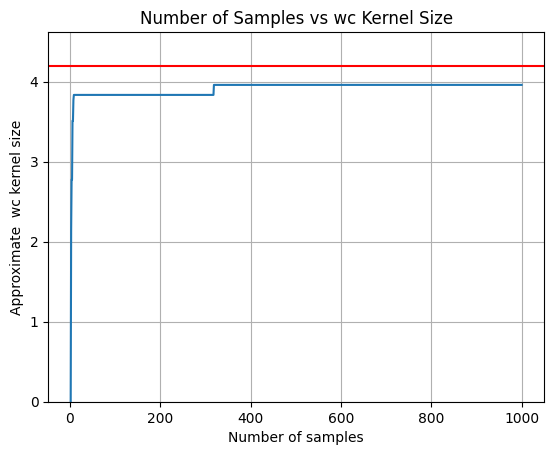

Total Max Kernel Size: 3.960226760145307
Analytical Kernel Size: 4.2
Relative Error: -0.05708886663206976


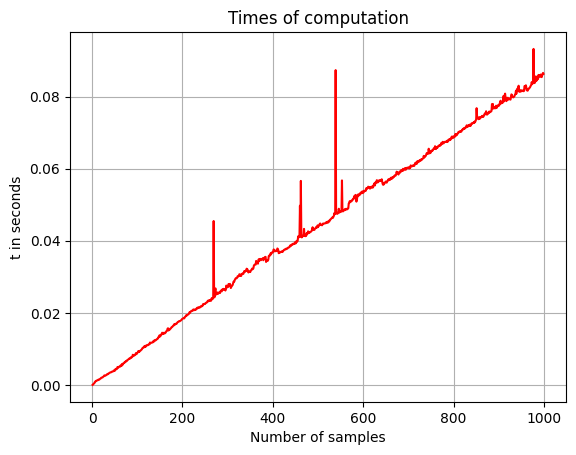

The last kernel size computation took 0.086298 seconds


In [3]:
# Step 2: Compute worst-case kernel sizes:
worstcase_kersize = worstcase_kernelsize(feasible_sets_list, p_1, p)

worstcase_kersize_list = []
times_comput = []
for k in range(0,max_k-1):
    t0 = time.time()
    worstcase_kersize =  worstcase_kernelsize(feasible_sets_list[:k], p_1, p)
    worstcase_kersize_list.append(worstcase_kersize)
    t1 = time.time()
    times_comput.append(t1-t0)

plot_wckersize_conv(worstcase_kersize, worstcase_kersize_list, wc_kernel_size_analytical, np.arange(2, max_k+1))

plot_times_comput(list(range(1,max_k,1)), times_comput)


100%|██████████| 50/50 [03:05<00:00,  3.71s/it]


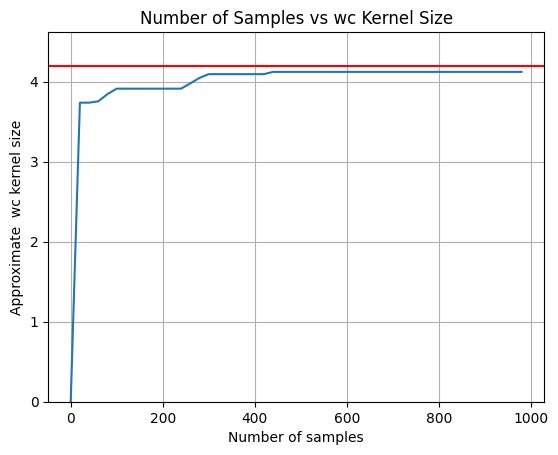

Total Max Kernel Size: 4.122991858728847
Analytical Kernel Size: 4.2
Relative Error: -0.018335271731226947


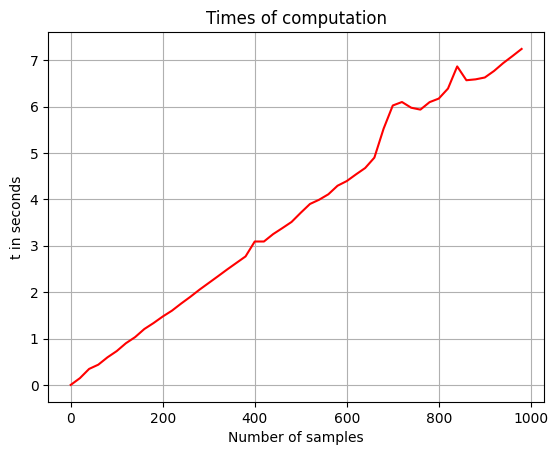

The last kernel size computation took 7.243780 seconds


In [6]:
# Step 2: Compute worst-case kernel sizes with symmetry assumption:
worstcase_kersize_sym = worstcase_kernelsize_sym(A, input_data[:input_target_pairs], target_data, p_1, p_2, p, 2*epsilon)

worstcase_kersize_sym_list = []
times_comput = []
iterations = range(0,max_k-1, 20)
for k in tqdm(iterations):
    t0 = time.time()
    worstcase_kersize_sym = worstcase_kernelsize_sym(A, input_data[:k], target_data, p_1, p_2, p, epsilon)
    worstcase_kersize_sym_list.append(worstcase_kersize_sym)
    t1 = time.time()
    times_comput.append(t1-t0)

plot_wckersize_conv(worstcase_kersize_sym, worstcase_kersize_sym_list, wc_kernel_size_analytical, list(iterations))
plot_times_comput(list(iterations), times_comput)

### Worst-case kernel size for linear forward model with additive noise, parallelized

In [7]:
#batch_size = 100

#input_loader1 = DataLoader(input_data, batch_size=batch_size, num_workers=batch_size, drop_last=False)
#input_loader2 = DataLoader(input_data, batch_size=batch_size, num_workers=batch_size, drop_last=False)
#target_loader1 = DataLoader(target_data, batch_size=batch_size, num_workers=batch_size, drop_last=False)
#target_loader2 = DataLoader(target_data, batch_size=batch_size, num_workers=batch_size, drop_last=False) 

First test the 2 ways of computing feasible appartenance

In [8]:
#t0 = time.time()
#feas_app_1 = feasibleApp_samplingYX_perbatch_cuda(input_data=input_loader1, forwarded_target= input_loader2, p_Y=2, epsilon=epsilon)
#t1 = time.time()
#feas_app_2 = feasibleApp_samplingYX_linear_cuda(input_loader1, input_loader2, p_Y=2, epsilon= epsilon, batchsize=50)
#t2 = time.time()

#print(f'Per batch : tool {t1-t0:.4f} seconds')
# print(f'With candidate selection : {t2-t1:.4f} seconds')


In [ ]:
#delta = feas_app_1 - feas_app_1.to(dtype=feas_app_1.dtype)
#print(f'Difference between the computations {delta.sum()}')

Then, test the worst-case kernel size computation with one of the two feasible appertinance matrix approaches and both precomputed target distances.

  0%|          | 0/15 [00:00<?, ?it/s]

  7%|▋         | 1/15 [00:02<00:35,  2.56s/it]

 13%|█▎        | 2/15 [00:05<00:32,  2.51s/it]

 20%|██        | 3/15 [00:07<00:32,  2.71s/it]

 27%|██▋       | 4/15 [00:11<00:33,  3.06s/it]

 33%|███▎      | 5/15 [00:16<00:35,  3.59s/it]

 40%|████      | 6/15 [00:21<00:38,  4.32s/it]

 47%|████▋     | 7/15 [00:27<00:38,  4.77s/it]

 53%|█████▎    | 8/15 [00:34<00:38,  5.52s/it]

 60%|██████    | 9/15 [00:41<00:35,  5.92s/it]

 67%|██████▋   | 10/15 [00:49<00:32,  6.47s/it]

 73%|███████▎  | 11/15 [00:57<00:28,  7.13s/it]

 80%|████████  | 12/15 [01:07<00:24,  8.02s/it]

 87%|████████▋ | 13/15 [01:19<00:18,  9.16s/it]

 93%|█████████▎| 14/15 [01:32<00:10, 10.27s/it]

100%|██████████| 15/15 [01:47<00:00,  7.17s/it]


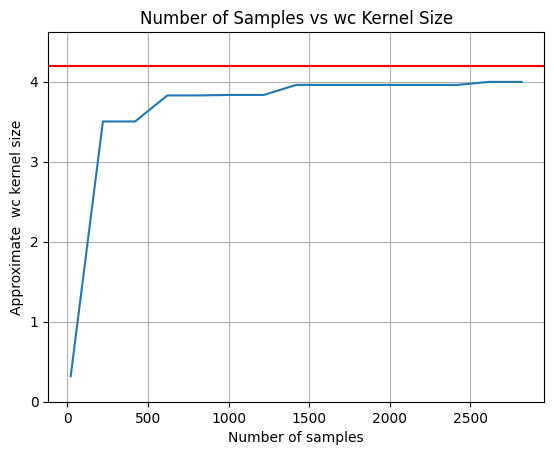

Total Max Kernel Size: 3.9979172144528965
Analytical Kernel Size: 4.2
Relative Error: -0.048114948939786586


In [ ]:
max_k = 3000
batch_size = 100
wc_kersizes = []
times_comput_FA = []
times_comput_WC = []

iterations = range(20,max_k,200)
for k in tqdm(iterations):
    input_data_k = input_data[0:k,:]
    target_data_k = target_data[0:k,:]
    input_loader1 = DataLoader(input_data_k, batch_size=batch_size, num_workers=batch_size, drop_last=False)
    input_loader2 = DataLoader(input_data_k, batch_size=batch_size, num_workers=batch_size, drop_last=False)
    target_loader1 = DataLoader(target_data_k, batch_size=batch_size, num_workers=batch_size, drop_last=False)
    target_loader2 = DataLoader(target_data_k, batch_size=batch_size, num_workers=batch_size, drop_last=False)   

    t0 = time.time()
    feasible_appartenance = feasibleApp_samplingYX_linear_cuda(input_loader1, input_loader2, p_Y=p_2, epsilon= epsilon, batchsize = k)
    feasible_appartenance = feasible_appartenance.to(dtype=torch.float32).to_sparse_coo()

    t1 = time.time()
    distsXX, feasible_appartenance = target_distances_samplingYX_precomputedFA_cuda_V2(target_loader1, feasible_appartenance, p_X=p_1, batchsize= k)
    
    
    feasible_appartenance = torch_csr_to_scipy(feasible_appartenance.cpu().to_sparse_csr())
    distsXX = torch_sparse_to_scipy_csr(distsXX)

    wc_kersize_k = worstcase_kernelsize_appartenance(distsXX, feasible_appartenance)
    t2 = time.time()
    times_comput_FA.append(t1-t0)
    times_comput_WC.append(t2-t1)
    wc_kersizes.append(wc_kersize_k)

wc_kersizef = wc_kersizes[-1]

plot_wckersize_conv(wc_kersizef, wc_kersizes, wc_kernel_size_analytical, list(iterations))



### Average kernel size

100%|██████████| 100/100 [00:05<00:00, 19.82it/s]


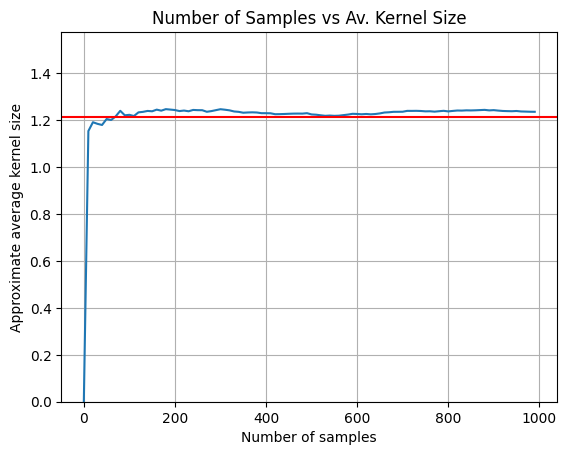

Total Max Kernel Size: 1.2363933756457715
Analytical Kernel Size: 1.2124355652982142
Relative Error: 0.019760068933365998


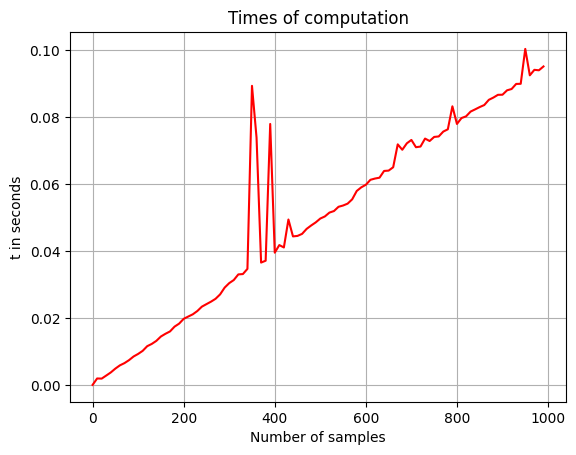

The last kernel size computation took 0.095167 seconds


In [3]:
max_k = 1000
# Step 2: Compute average kernel sizes:
average_kersize = average_kernelsize(feasible_sets_list, p_1, p)

average_kersize_list = []
times_comput = []

iterations = range(0,max_k,10)
for k in tqdm(iterations):
    t0 = time.time()
    average_kersize =  average_kernelsize(feasible_sets_list[:k], p_1, p)
    average_kersize_list.append(average_kersize)
    t1 = time.time()
    times_comput.append(t1-t0)

plot_avkersize_conv(average_kersize,average_kersize_list, av_kernel_size_analytical, list(iterations))
plot_times_comput(list(iterations), times_comput)

100%|██████████| 34/34 [02:10<00:00,  3.84s/it]


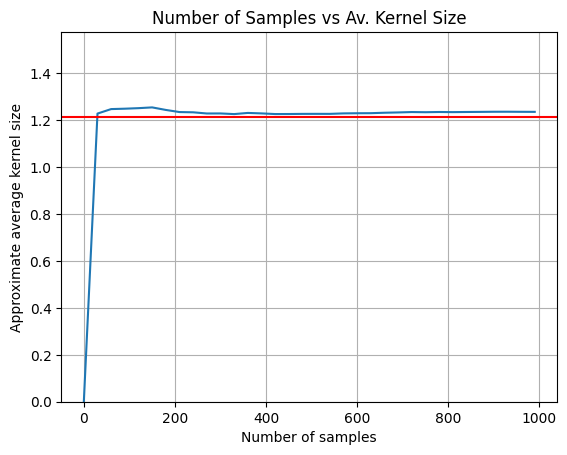

Total Max Kernel Size: 1.2361252973314236
Analytical Kernel Size: 1.2124355652982142
Relative Error: 0.019538961666290825


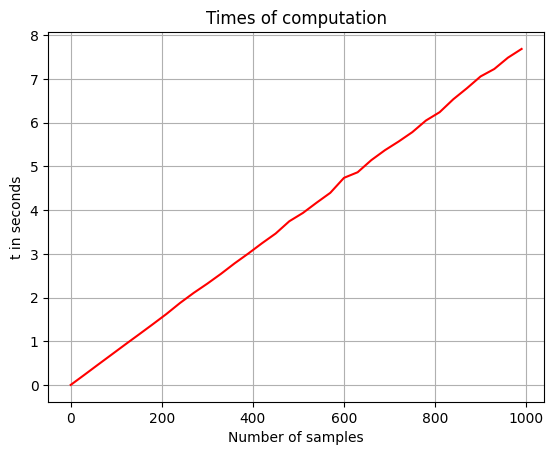

The last kernel size computation took 7.690578 seconds


In [4]:
# Step 2: Compute average symmetric kernel sizes:
average_kersize_sym = average_kernelsize_sym(A, input_data, target_data, p_1, p_2, p, epsilon)

average_kersize_sym_list = []
times_comput = []
iterations = range(0,max_k, 30)
for k in tqdm(iterations):
    t0 = time.time()
    average_kersize_sym =  average_kernelsize_sym(A, input_data[:k], target_data, p_1, p_2, p, epsilon)
    average_kersize_sym_list.append(average_kersize_sym)
    t1 = time.time()
    times_comput.append(t1-t0)

plot_avkersize_conv(average_kersize_sym,average_kersize_sym_list, av_kernel_size_analytical,list(iterations))
plot_times_comput(list(iterations), times_comput)

### Average kernel size for linear forward model with additive noise, parallelized

  0%|          | 0/15 [00:00<?, ?it/s]

  7%|▋         | 1/15 [00:00<00:05,  2.59it/s]

 13%|█▎        | 2/15 [00:01<00:08,  1.54it/s]

 20%|██        | 3/15 [00:02<00:10,  1.15it/s]

 27%|██▋       | 4/15 [00:04<00:13,  1.19s/it]

 33%|███▎      | 5/15 [00:06<00:16,  1.63s/it]

 40%|████      | 6/15 [00:10<00:21,  2.34s/it]

 47%|████▋     | 7/15 [00:14<00:22,  2.84s/it]

 53%|█████▎    | 8/15 [00:19<00:25,  3.62s/it]

 60%|██████    | 9/15 [00:24<00:24,  4.06s/it]

 67%|██████▋   | 10/15 [00:30<00:23,  4.76s/it]

 73%|███████▎  | 11/15 [00:38<00:22,  5.60s/it]

 80%|████████  | 12/15 [00:46<00:19,  6.55s/it]

 87%|████████▋ | 13/15 [00:57<00:15,  7.77s/it]

 93%|█████████▎| 14/15 [01:09<00:09,  9.07s/it]

100%|██████████| 15/15 [01:23<00:00,  5.56s/it]


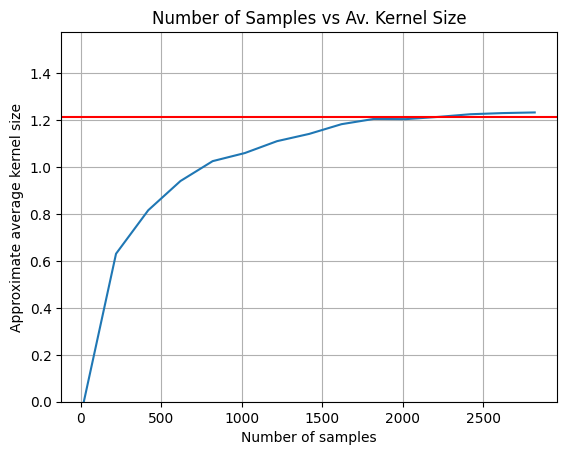

Total Max Kernel Size: 1.2336317847155347
Analytical Kernel Size: 1.2124355652982142
Relative Error: 0.017482347123417685


In [6]:
max_k = 3000
batch_size = 10
av_kersizes = []
times_comput_FA = []
times_comput_AV = []

iterations = range(20,max_k,200)

for k in tqdm(iterations):
    input_data_k = input_data[0:k,:]
    target_data_k = target_data[0:k,:]
    input_loader1 = DataLoader(input_data_k, batch_size=batch_size, num_workers=batch_size, drop_last=False)
    input_loader2 = DataLoader(input_data_k, batch_size=batch_size, num_workers=batch_size, drop_last=False)
    target_loader1 = DataLoader(target_data_k, batch_size=batch_size, num_workers=batch_size, drop_last=False)
    target_loader2 = DataLoader(target_data_k, batch_size=batch_size, num_workers=batch_size, drop_last=False)   

    t0 = time.time()
    feasible_appartenance = feasibleApp_samplingYX_linear_cuda(input_loader1, input_loader2, p_Y=p_2, epsilon= epsilon, batchsize = k)
    feasible_appartenance = feasible_appartenance.to(dtype=torch.float32).to_sparse_coo()

    t1 = time.time()
    distsXX, feasible_appartenance = target_distances_samplingYX_precomputedFA_cuda_V2(target_loader1, feasible_appartenance, p_X=p_1, batchsize= k)
    
    
    feasible_appartenance = torch_csr_to_scipy(feasible_appartenance.cpu().to_sparse_csr())
    distsXX = torch_sparse_to_scipy_csr(distsXX)

    av_kersize_k = avgLB_samplingYX(distsXX, feasible_appartenance, p_X=2)
    t2 = time.time()
    times_comput_FA.append(t1-t0)
    times_comput_AV.append(t2-t1)
    av_kersizes.append(av_kersize_k)

av_kersizef = av_kersizes[-1]

plot_avkersize_conv(av_kersizef, av_kersizes, av_kernel_size_analytical, list(iterations))